# homework 2: tf-idf
by arkady shaldov, group 213

### task 1. word2vec

imports, mainly for preprocessing

In [ ]:
from pymystem3 import Mystem
from os import listdir
from nltk import sent_tokenize
from nltk.corpus import stopwords
from re import finditer
m = Mystem()
sw = stopwords.words('russian')

#### pre-processing

lemmatizer, punctuation and stopword filter

In [2]:
def ltz(text):
    return ' '.join((word for word in m.lemmatize(text) if any(letter.isalnum() for letter in word) and word not in sw)) + '\n'

mini-function that removes initial metadata (the book itself always starts with )

In [ ]:
def crop_heading(text):
    fi = finditer('', text)
    next(fi)
    return text[next(fi).start():]

splitting every book in sentences, lemmatizing, and writing into the common file line by line

In [ ]:
with open('lemmatized.txt', 'w', encoding='utf-8') as lemmatized:
    for filename in listdir('books'):
        with open('books/' + filename, encoding='koi8-r') as book:
            text = crop_heading(book.read())
            for row in [sent_tokenize(row) for row in text.split('\n')]:
                for sent in row:
                    lemmatized.write(ltz(sent))

#### the model

initializing gensim

In [3]:
from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec
from logging import basicConfig, INFO

In [4]:
basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=INFO)

reading the data, training and saving the model

In [5]:
data = LineSentence('lemmatized.txt')

In [6]:
model_fdn = Word2Vec(data, vector_size=300, window=5, min_count=5, epochs=50)

2022-11-15 19:14:59,174 : INFO : collecting all words and their counts
2022-11-15 19:14:59,182 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-11-15 19:14:59,231 : INFO : PROGRESS: at sentence #10000, processed 60024 words, keeping 13969 word types
2022-11-15 19:14:59,271 : INFO : PROGRESS: at sentence #20000, processed 120149 words, keeping 20399 word types
2022-11-15 19:14:59,309 : INFO : PROGRESS: at sentence #30000, processed 182700 words, keeping 24654 word types
2022-11-15 19:14:59,344 : INFO : PROGRESS: at sentence #40000, processed 241837 words, keeping 26925 word types
2022-11-15 19:14:59,375 : INFO : PROGRESS: at sentence #50000, processed 295717 words, keeping 29706 word types
2022-11-15 19:14:59,412 : INFO : PROGRESS: at sentence #60000, processed 355857 words, keeping 31979 word types
2022-11-15 19:14:59,459 : INFO : PROGRESS: at sentence #70000, processed 417512 words, keeping 34166 word types
2022-11-15 19:14:59,512 : INFO : PROGRESS: at s

In [7]:
# model_fdn.init_sims(replace=True)
model_path = "fdn.bin"
model_fdn.wv.save_word2vec_format(model_path, binary=True)

2022-11-15 19:15:35,897 : INFO : storing 13273x300 projection weights into fdn.bin


13

13 thousand words — pretty good considering the minimum entry count

In [8]:
len(model_fdn.wv)

13273

#### fruits of training

a character's name is most similar to characters' names, unsurprisingly

In [9]:
model_fdn.wv.most_similar('фандорин')

[('фандорина', 0.4034789800643921),
 ('вице-консул', 0.39114436507225037),
 ('мидори', 0.3584604859352112),
 ('консул', 0.3438311219215393),
 ('гэндзи', 0.3389842212200165),
 ('юми', 0.33604681491851807),
 ('петрович', 0.32428693771362305),
 ('асагава', 0.3218904733657837),
 ('эраст', 0.3141874372959137),
 ('ника', 0.31070953607559204)]

an abstract concept is most similar to other abstract concepts and semantically connected stuff

In [10]:
model_fdn.wv.most_similar('смерть')

[('гдлевский', 0.31558549404144287),
 ('любовник', 0.3139645457267761),
 ('самоубийство', 0.30136266350746155),
 ('ненависть', 0.2989954948425293),
 ('любовь', 0.2944874167442322),
 ('пошлый', 0.28136980533599854),
 ('умирать', 0.27763769030570984),
 ('самолюбие', 0.26560327410697937),
 ('круть', 0.26460370421409607),
 ('калибан', 0.2590222954750061)]

antonymic adverbs return some other adverbs and some collocates

In [11]:
model_fdn.wv.most_similar(['быстро', 'медленно'])

[('негромко', 0.39126384258270264),
 ('волноваться', 0.3793197274208069),
 ('осторожно', 0.3756802976131439),
 ('зашагать', 0.3737246096134186),
 ('кран', 0.3733035922050476),
 ('лезвие', 0.36589908599853516),
 ('неловко', 0.3605267405509949),
 ('расплываться', 0.35300445556640625),
 ('разматывать', 0.3510517477989197),
 ('нескладно', 0.3492940068244934)]

the model did well with distinguishing a transitive verb from intransitive ones with close semantics

In [12]:
model_fdn.wv.doesnt_match(['идти', 'ехать', 'двигаться', 'везти'])

'везти'

# task 2. w2v pre-trained

In [13]:
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
pca = PCA(n_components=2)

downloading, extracting, and initializing a model

In [14]:
from urllib.request import urlretrieve
url = "http://vectors.nlpl.eu/repository/20/220.zip"
urlretrieve(url, "pre_model.zip")

('pre_model.zip', <http.client.HTTPMessage at 0x7a8e5ef627c0>)

In [15]:
import zipfile
with zipfile.ZipFile('pre_model.zip', 'r') as zip_ref:
    zip_ref.extractall('pre_model')

In [16]:
pre_model = KeyedVectors.load_word2vec_format('pre_model/model.bin', binary=True)

2022-11-15 19:17:58,190 : INFO : loading projection weights from pre_model/model.bin
2022-11-15 19:18:00,055 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (249333, 300) matrix of type float32 from pre_model/model.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2022-11-15T19:18:00.055775', 'gensim': '4.2.0', 'python': '3.9.2 (default, Feb 28 2021, 17:03:44) \n[GCC 10.2.1 20210110]', 'platform': 'Linux-5.10.147-20147-gbf231eecc4e8-x86_64-with-glibc2.31', 'event': 'load_word2vec_format'}


counting semantic proportions has met a fiasco

In [17]:
pre_model.most_similar(positive=['большой_ADJ', 'маленький_ADJ'], negative=['тяжелый_ADJ'], topn=1)[0][0]

'небольшой_ADJ'

#### visualizing vectors for some (clustering) countries with PCA

In [ ]:
words = ('украина_PROPN', 'япония_PROPN', 'россия_PROPN', 'израиль_PROPN', 'белоруссия_PROPN', 'китай_PROPN', 'германия_PROPN', 'франция_PROPN', 'корея_PROPN', 'вьетнам_PROPN')
coords = pca.fit_transform(pre_model[words])

solid, isn't it (these are the countries with the best results though)

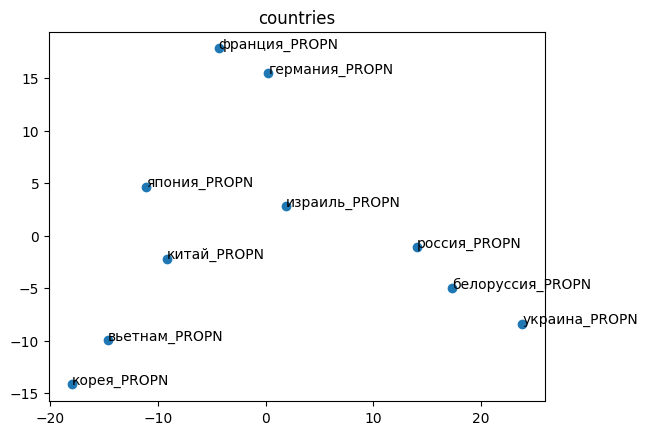

In [20]:
plt.scatter(coords[:, 0], coords[:, 1])
plt.title('countries')

for i, word in enumerate(words):
    plt.annotate(word, xy=(coords[i, 0], coords[i, 1]))
plt.show()

#### pseudo-synonymic substitution

In [21]:
def synonym(word):
    for entry in pre_model.key_to_index:
        if entry[:entry.find('_')] == word:
            res = pre_model.most_similar(entry)[0][0]
            return res[:res.find('_')]
    return word

In [22]:
sent = 'Руками он брался за горячий стакан с крепким чаем и передвигал шахматные фигурки.'
''.join((synonym(word) if not word in sw else word for word in m.lemmatize(sent)))[:-1]

'ладонь он взяться за горячий рюмка с крепка кофе и переставлять шашечный фигура.'

let it be like *Ладонью он взялся за горячую рюмку с крепким кофе и переставлял шашечную фигуру.* some words unchanged, probably morphology problems.

# task 3. wikipedia tf-idf

gathering data here with the wikipedia api

In [23]:
import wikipediaapi
wp = wikipediaapi.Wikipedia('ru')

In [25]:
from os import mkdir

the articles shall belong here

In [ ]:
mkdir('wp')

retrieving the alphabetically first 10 articles from a category and writing them into their own file

In [26]:
def get_articles(category, name):
    i = 0
    for article in category.categorymembers.values():
        if i == art_num:
            return
        if article.ns != wikipediaapi.Namespace.CATEGORY and article.text:
            with open(f'wp/{name}_{article.title}.txt', 'w', encoding='utf-8') as f:
                f.write(ltz(article.text))
                i += 1

codenames, wikipedia names, and visualization colors for the categories

In [27]:
art_num = 10
cats = (('cars', 'Автомобили', '#c70a0a'),
        ('linguistics', 'Лингвистика', '#20ad03'),
        ('literature', 'Литературоведение', '#a614a6'),
        ('mathematics', 'Математика', '#1e2fc7'),
        ('philosophy', 'Философия', '#0bb8b5'),
        ('sociology', 'Социология', '#f2ea07'))

In [ ]:
for c in cats:
    get_articles(wp.page(f'Category:{c[1]}'), c[0])

reading the article files into a list and creating a tf-idf matrix

In [28]:
from os import listdir
articles = [open(f'wp/{f}', encoding='utf-8').read() for f in sorted(listdir('wp'))]

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer="word", ngram_range=(1, 3), min_df=3)

In [30]:
matrix = tfidf.fit_transform(articles)

In [32]:
len(tfidf.get_feature_names_out())

2352

#### keyword extraction

In [33]:
from numpy import array, argsort

getting top instances for a matrix row

In [34]:
def top_words(vector, feature_names, top_n=5):
    sorted_nzs = argsort(vector.data)[:-(top_n+1):-1]
    return feature_names[vector.indices[sorted_nzs]]

keywords for every article here

In [36]:
for i, article in enumerate(articles):
    print(cats[i // art_num][0])
    print(', '.join(top_words(matrix[i, :], array(tfidf.get_feature_names_out()))))

cars
грузовик, автомобиль, популярный, chevrolet, 1950
cars
грузовик, замена, производство, год, производиться
cars
2014, январь, украина, лидер, акция
cars
автомобиль, машина, устройство, война, мочь
cars
автомобиль, около, окружающий среда, отправляться, окружающий
cars
работа, устойчивость, напряжение, автомобиль, возможность
cars
город, автомобиль, транспорт, зона, общественный
cars
автомобиль, городской, малый, низкий, год
cars
пассажирский, место, использоваться, автомобиль, мочь
cars
автомобиль, дизайн, производиться, появление, history
linguistics
язык, слово, около, грамматический, употребляться
linguistics
поэзия, ред, начало, следующий, русский
linguistics
выражение, лингвистика, связь, разрешение, местоимение
linguistics
язык, атлас, угроза, находиться, язык который
linguistics
язык, текст, известный, год, греческий
linguistics
вариант, единица, класс, языковой, уровень
linguistics
глагол, синтаксический, трансформация, речь, смысл
linguistics
лингвистика, язык, изучать, яз

#### visualizing the articles

In [37]:
art_coords = pca.fit_transform(matrix.toarray())

plots the articles for a single category, with its own color

In [38]:
def plot_cats(catnums, plot):
    for i, cat in zip(catnums, (cats[num] for num in catnums)):
        plot.scatter(art_coords[10 * i:10 * (i + 1), 0], art_coords[10 * i:10 * (i + 1), 1], color=cat[2])

the results, with zooming in slowly. vehicles and linguistics being clear outsiders, math, philosophy and sociology articles are seemingly indistinguishable

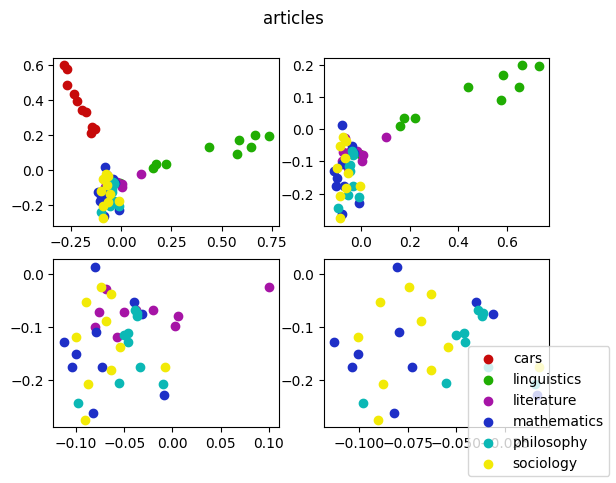

In [39]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('articles')

plot_cats(range(6),    axs[0, 0])
plot_cats(range(1, 6), axs[0, 1])
plot_cats(range(2, 6), axs[1, 0])
plot_cats(range(3, 6), axs[1, 1])

plt.figlegend([cat[0] for cat in cats], loc='lower right')
plt.show()

# part 4. tf-idf extended

`token_pattern` getting a regex that only accepts alphabetic characters (both cyrillic and latin)

In [40]:
alpha_tfidf = TfidfVectorizer(analyzer="word", token_pattern=r'\b[a-zA-Zа-яА-ЯёЁ]+\b', ngram_range=(1, 3), min_df=3)
alpha_matrix = alpha_tfidf.fit_transform(articles)

28 number-words lost.

In [42]:
len(alpha_tfidf.get_feature_names_out())

2324

getting a text-to-text cosine-similarity matrix

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(alpha_matrix)

retrieving most similar articles except for the article itself

In [45]:
def cos_most_similar(num):
    return [articles[i] for i in cos_sim[num].argsort()[-2:-5:-1]]

the most similar text to the one about the Bedford TA is the one about the Bedford S-Type

In [46]:
cos_most_similar(1)

['Bedford S Type это бескапотный грузовик среднетоннажный категория который производиться компания Bedford Vehicles 1950 1959 год качество первый модель грузовик кабина грузовик Bedford QL история автомобиль впервые представлять коммерческий автосалон 1950 год основывать грузовик Chevrolet Advance Design COE время который время становиться относительно популярный соединенный штат автомобиль запускать производство время намереваться конкурировать аналогичный грузовик Leyland Comet ERF KV который также выходить рынок время хотя S Type иметь двигатель Chevrolet который иметь больший мощность оба поэтому популярный рынок из-за высокий выходной мощность надежность автомобиль выбирать различный служба также использоваться армия также экспортироваться многий страна 1959 год производить 90 000 грузовик пока смена приходить современный грузовик Bedford TK который популярный предшественник модификация Bedford RL военный версия Bedford SRHZ пожарный машина база шасси автомобиль внешний ссылка The

the one most similar to 'Deus ex Machina' is some math (probably Fourier)

In [47]:
cos_most_similar(37)

['уравнение пятый степень называть уравнение вид a x 5 b x 4 c x 3 d x 2 e x f 0 displaystyle ax 5 bx 4 cx 3 dx 2 ex f 0 теорема виета уравнение пятый степень корень уравнение пятый степень x 1 x 2 x 3 x 4 x 5 displaystyle x 1 x 2 x 3 x 4 x 5 связанный коэффициент a b c d e f displaystyle a b c d e f следующий образ x 1 x 2 x 3 x 4 x 5 b a displaystyle x 1 x 2 x 3 x 4 x 5 frac b a x 1 x 2 x 1 x 3 x 1 x 4 x 1 x 5 x 2 x 3 x 2 x 4 x 2 x 5 x 3 x 4 x 3 x 5 x 4 x 5 c a displaystyle x 1 x 2 x 1 x 3 x 1 x 4 x 1 x 5 x 2 x 3 x 2 x 4 x 2 x 5 x 3 x 4 x 3 x 5 x 4 x 5 frac c a x 1 x 2 x 3 x 1 x 2 x 4 x 1 x 2 x 5 x 1 x 3 x 4 x 1 x 3 x 5 x 1 x 4 x 5 x 2 x 3 x 4 x 2 x 3 x 5 x 2 x 4 x 5 x 3 x 4 x 5 d a displaystyle x 1 x 2 x 3 x 1 x 2 x 4 x 1 x 2 x 5 x 1 x 3 x 4 x 1 x 3 x 5 x 1 x 4 x 5 x 2 x 3 x 4 x 2 x 3 x 5 x 2 x 4 x 5 x 3 x 4 x 5 frac d a x 1 x 2 x 3 x 4 x 1 x 2 x 3 x 5 x 1 x 2 x 4 x 5 x 1 x 3 x 4 x 5 x 2 x 3 x 4 x 5 e a displaystyle x 1 x 2 x 3 x 4 x 1 x 2 x 3 x 5 x 1 x 2 x 4 x 5 x 1 x 3 x 4 x 5 x 2

#### cluster map for cosine similarity
articles are actually clustering together (cf. the indices on the right), cars, sociology, and philosophy doing the best job. linguistics seem distributed, contradicting the PCA visualization.

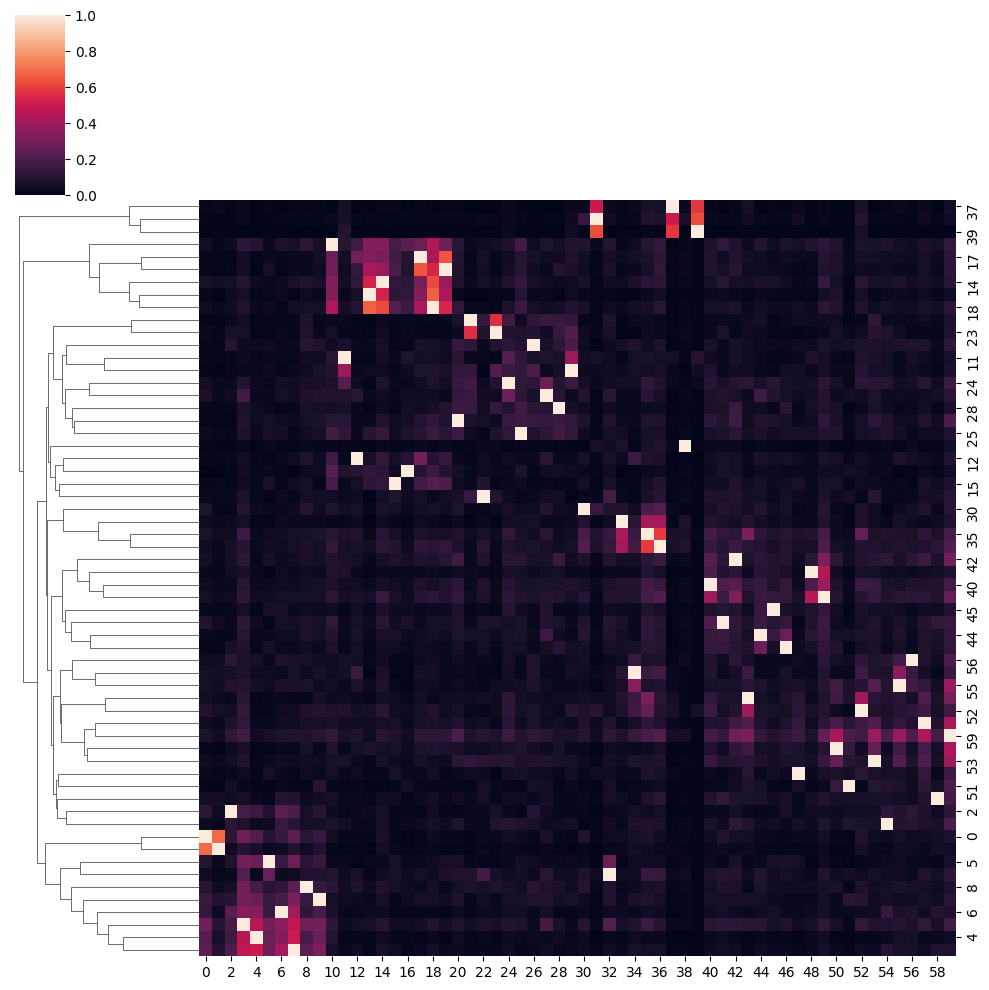

In [49]:
from seaborn import clustermap
cm = clustermap(cos_sim, col_cluster=False)